# Project 3 Web APIs & NLP - Florian Combelles

In week four we've learned about a few different classifiers. In week five we'll learn about webscraping, APIs, and Natural Language Processing (NLP). This project will put those skills to the test.

For project 3, your goal is two-fold:
1. Using [Pushshift's](https://github.com/pushshift/api) API, you'll collect posts from two subreddits of your choosing.
2. You'll then use NLP to train a classifier on which subreddit a given post came from. This is a binary classification problem.

###### Requirements

- Gather and prepare your data using the `requests` library.
- **Create and compare two models**. One of these must be a Naive Bayes classifier, however the other can be a classifier of your choosing: logistic regression, KNN, SVM, etc.
- A Jupyter Notebook with your analysis for a peer audience of data scientists.
- An executive summary of your results.
- A short presentation outlining your process and findings for a semi-technical audience.

## Problem Statement and background

###### Problem Statement

During Covid 19, we have seen an increase in the number of new pet owners in Singapore.
These new inexperienced pet owners are facing a lack of ressources on how to care for their new pets.

This leads to them having to overrely on veterinarians and pet stores to provides information and respond to their queries.

This influx of inexperienced pets owners overly reliant on vets and pet store reduces their work efficiency and distract them from their main responsibilites


##### Background

We are working for a company called Pet Smart.

We are releasing a new mobile app that includes two features:
* A chat box where you can ask your cat or dog related question and get an answer from a team of experts.
* Articles that provides informations and tips on how to care for your pets.

## Part 4: Hyperparameter Tuning, Word2Vec and Conclusion

In this section, we will use Pipelines and Hyperparameter tuning to see if we can increase the results of our models.
Unlike the previous part were we manually keyed in parameters for both our Vectorizer, we will be making use of the Pipeline and GridSearchCV modules from SKLearnto automate the search for the best parameters.


We will also use Word2Vec to create a model that will return the most similar words based on our dataset.

##### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

import gensim

##### Loading non vectorized dataset

Since we will be looking for the best parameters for our Vectorizer and models we will need to load the non vectorized data.

In [2]:
cat_dog = pd.read_csv('data/cat_dog.csv')

In [3]:
cat_dog.columns

Index(['Unnamed: 0', 'created_utc', 'domain', 'is_robot_indexable', 'selftext',
       'subreddit', 'title', 'post_hint', 'content_word_count',
       'content_lemmatized', 'content_joined'],
      dtype='object')

##### Define X and Y variables

We are defining new X and Y variables that will be used by all the models

In [4]:
X = cat_dog['content_joined']
y = cat_dog['subreddit']

##### Define Variables

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    stratify=y,
                                                    random_state=1)

### Multinomial Naive Bayes

##### Using CountVectorizer

##### Create a Pipeline to identify best CountVectorizer parameters

We are creating a pipeline that will include the Vectorizing method along with the Model

In [6]:
pipe_cv_mn = Pipeline([('cvec_mn', CountVectorizer()),
                ('nb_cv', MultinomialNB())])

In [7]:
# Printing the parameters for our pipeline

pipe_cv_mn.get_params()

{'memory': None,
 'steps': [('cvec_mn', CountVectorizer()), ('nb_cv', MultinomialNB())],
 'verbose': False,
 'cvec_mn': CountVectorizer(),
 'nb_cv': MultinomialNB(),
 'cvec_mn__analyzer': 'word',
 'cvec_mn__binary': False,
 'cvec_mn__decode_error': 'strict',
 'cvec_mn__dtype': numpy.int64,
 'cvec_mn__encoding': 'utf-8',
 'cvec_mn__input': 'content',
 'cvec_mn__lowercase': True,
 'cvec_mn__max_df': 1.0,
 'cvec_mn__max_features': None,
 'cvec_mn__min_df': 1,
 'cvec_mn__ngram_range': (1, 1),
 'cvec_mn__preprocessor': None,
 'cvec_mn__stop_words': None,
 'cvec_mn__strip_accents': None,
 'cvec_mn__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec_mn__tokenizer': None,
 'cvec_mn__vocabulary': None,
 'nb_cv__alpha': 1.0,
 'nb_cv__class_prior': None,
 'nb_cv__fit_prior': True}

##### Define GridSearchCV parameters

Defining our parameters for the current Vectorizing method and Model.

In [8]:
pipe_cv_mn_params = {
    'cvec_mn__max_features': [9_000], #[3_000, 4_000, 7_000, 9_000],
    'cvec_mn__min_df': [2], #[2, 3],
    'cvec_mn__max_df': [0.5], #[0.5 ,.7 ,.9],
    'cvec_mn__ngram_range': [(1,2)]} #[(1,1), (1,2)]}

##### Instantiate GridSearchCV

Now that we have our parameters, we can fit our model with the parameters list.

The GridSearchCV will then test all the different combinations of parameters and return the optimal settings that will provide the highest results.

In [9]:
gs_cv_mn = GridSearchCV(pipe_cv_mn, param_grid=pipe_cv_mn_params, cv=5)

In [10]:
gs_cv_mn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec_mn', CountVectorizer()),
                                       ('nb_cv', MultinomialNB())]),
             param_grid={'cvec_mn__max_df': [0.5],
                         'cvec_mn__max_features': [9000],
                         'cvec_mn__min_df': [2],
                         'cvec_mn__ngram_range': [(1, 2)]})

In [11]:
gs_cv_mn.best_score_

0.8786390242644593

In [12]:
gs_cv_mn.best_params_

{'cvec_mn__max_df': 0.5,
 'cvec_mn__max_features': 9000,
 'cvec_mn__min_df': 2,
 'cvec_mn__ngram_range': (1, 2)}

In [13]:
crossval_gs_cv_mn = cross_val_score(gs_cv_mn, X_train, y_train, cv=5)
crossvalavg_gs_cv_mn = cross_val_score(gs_cv_mn, X_train, y_train, cv=5).mean()
gs_cv_mn_score = gs_cv_mn.score(X_train, y_train)

print(f'CrossVal Score:{crossval_gs_cv_mn}')
print(f'Average CrossVal Score: {crossvalavg_gs_cv_mn}')
print(f'Model Score: {gs_cv_mn_score}')

CrossVal Score:[0.88172043 0.88888889 0.92114695 0.8705036  0.83093525]
Average CrossVal Score: 0.8786390242644593
Model Score: 0.968413496051687


In [14]:
y_pred_gs_cv_mn = gs_cv_mn.predict(X_test)

accuracy_gs_cv_mn = accuracy_score(y_test, y_pred_gs_cv_mn)
recall_gs_cv_mn = recall_score(y_test, y_pred_gs_cv_mn)
precision_gs_cv_mn = precision_score(y_test, y_pred_gs_cv_mn)
f1_gs_cv_mn = f1_score(y_test, y_pred_gs_cv_mn)

print(f'Prediction Accuracy: {accuracy_gs_cv_mn}\nPrediction Recall: {recall_gs_cv_mn}\nPrediction Precision: {precision_gs_cv_mn}\nPrediction F1: {f1_gs_cv_mn}')

Prediction Accuracy: 0.8879598662207357
Prediction Recall: 0.8523489932885906
Prediction Precision: 0.9169675090252708
Prediction F1: 0.8834782608695652


In [15]:
# Plotting Confusion Matrix

cm_gs_cv_mn = confusion_matrix(y_test, y_pred_gs_cv_mn)

annot_labels = []
for index,value in enumerate(cm_gs_cv_mn):
    if index == 0:
        annot_labels.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        annot_labels.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])]);

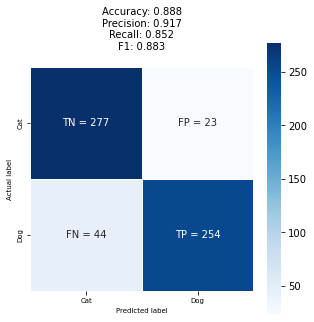

In [16]:
plt.figure(figsize=(5,5))
sns.heatmap(cm_gs_cv_mn, annot=np.array(annot_labels),
            fmt="",
            annot_kws={"size": 10},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Cat', 'Dog'],
            yticklabels = ['Cat', 'Dog'],
            );

plt.ylabel('Actual label', fontsize = 7);
plt.xlabel('Predicted label', fontsize = 7);
plt.title('Accuracy: {:.3f}'.format(accuracy_gs_cv_mn)+'\n'
          +'Precision: {:.3f}'.format(precision_gs_cv_mn)+'\n'
          +'Recall: {:.3f}'.format(recall_gs_cv_mn)+'\n'
          +'F1: {:.3f}'.format(f1_gs_cv_mn)+'\n', size = 10);
plt.tick_params(labelsize= 7)

C:\Users\flori\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


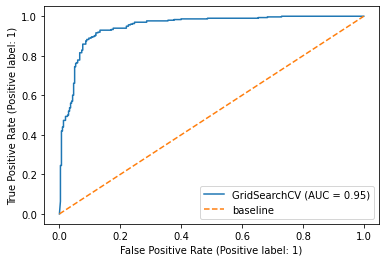

In [17]:
plot_roc_curve(gs_cv_mn, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [18]:
gs_cv_mn.best_estimator_

Pipeline(steps=[('cvec_mn',
                 CountVectorizer(max_df=0.5, max_features=9000, min_df=2,
                                 ngram_range=(1, 2))),
                ('nb_cv', MultinomialNB())])

In [19]:
gs_cv_mn.best_estimator_["cvec_mn"].get_feature_names_out()

array(['abandoned', 'ability', 'able', ..., 'zone', 'zoom', 'zoomies'],
      dtype=object)

In [20]:
gs_cv_mn.best_estimator_["nb_cv"].feature_log_prob_[0]

array([ -8.90908662, -10.11305942,  -6.84222386, ..., -10.11305942,
       -10.11305942,  -8.81377644])

In [21]:
gs_cv_mn.best_estimator_["nb_cv"].feature_log_prob_[1]

array([ -9.08042149, -10.17903378,  -6.92093724, ..., -10.87218096,
       -10.87218096, -10.87218096])

In [22]:
prob_df = gs_cv_mn.best_estimator_["nb_cv"].feature_log_prob_[1] - gs_cv_mn.best_estimator_["nb_cv"].feature_log_prob_[0]

In [23]:
pd.DataFrame({"feature":gs_cv_mn.best_estimator_["cvec_mn"].get_feature_names_out(),
             'coef': prob_df }).sort_values(by='coef', ascending=False)

,feature,coef
4971,pup,4.616157
7101,teeth,4.077160
511,bark,4.028370
2809,golden,3.977077
621,bichon,3.835998
...,...,...
715,box,-3.729536
3829,litter,-3.735218
4072,meowing,-3.787644
3830,litter box,-4.109026


##### Using Term Frequency - Inverse Document Frequency

##### Create a Pipeline to identify best CountVectorizer parameters

In [24]:
pipe_tfidf_mn = Pipeline([('tfidf_mn', TfidfVectorizer()),
                ('nb_tfidf', MultinomialNB())])

In [25]:
pipe_tfidf_mn.get_params()

{'memory': None,
 'steps': [('tfidf_mn', TfidfVectorizer()), ('nb_tfidf', MultinomialNB())],
 'verbose': False,
 'tfidf_mn': TfidfVectorizer(),
 'nb_tfidf': MultinomialNB(),
 'tfidf_mn__analyzer': 'word',
 'tfidf_mn__binary': False,
 'tfidf_mn__decode_error': 'strict',
 'tfidf_mn__dtype': numpy.float64,
 'tfidf_mn__encoding': 'utf-8',
 'tfidf_mn__input': 'content',
 'tfidf_mn__lowercase': True,
 'tfidf_mn__max_df': 1.0,
 'tfidf_mn__max_features': None,
 'tfidf_mn__min_df': 1,
 'tfidf_mn__ngram_range': (1, 1),
 'tfidf_mn__norm': 'l2',
 'tfidf_mn__preprocessor': None,
 'tfidf_mn__smooth_idf': True,
 'tfidf_mn__stop_words': None,
 'tfidf_mn__strip_accents': None,
 'tfidf_mn__sublinear_tf': False,
 'tfidf_mn__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf_mn__tokenizer': None,
 'tfidf_mn__use_idf': True,
 'tfidf_mn__vocabulary': None,
 'nb_tfidf__alpha': 1.0,
 'nb_tfidf__class_prior': None,
 'nb_tfidf__fit_prior': True}

##### Define GridSearchCV parameters

In [26]:
pipe_tfidf_mn_params = {
    'tfidf_mn__max_features': [9_000], #[3_000, 4_000, 7_000, 9_000],
    'tfidf_mn__min_df': [2], #[2, 3],
    'tfidf_mn__max_df': [0.5]} #[0.5 ,.7 ,.9]}

##### Instantiate GridSearchCV

In [27]:
gs_tfidf_mn = GridSearchCV(pipe_tfidf_mn, param_grid=pipe_tfidf_mn_params, cv=5)

In [28]:
gs_tfidf_mn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf_mn', TfidfVectorizer()),
                                       ('nb_tfidf', MultinomialNB())]),
             param_grid={'tfidf_mn__max_df': [0.5],
                         'tfidf_mn__max_features': [9000],
                         'tfidf_mn__min_df': [2]})

In [29]:
gs_tfidf_mn.best_score_

0.839148036409582

In [30]:
gs_tfidf_mn.best_params_

{'tfidf_mn__max_df': 0.5,
 'tfidf_mn__max_features': 9000,
 'tfidf_mn__min_df': 2}

In [31]:
crossval_gs_tfidf_mn = cross_val_score(gs_tfidf_mn, X_train, y_train, cv=5)
crossvalavg_gs_tfidf_mn = cross_val_score(gs_tfidf_mn, X_train, y_train, cv=5).mean()
gs_tfidf_mn_score = gs_tfidf_mn.score(X_train, y_train)

print(f'CrossVal Score:{crossval_gs_tfidf_mn}')
print(f'Average CrossVal Score: {crossvalavg_gs_tfidf_mn}')
print(f'Model Score: {gs_tfidf_mn_score}')

CrossVal Score:[0.82437276 0.88172043 0.8781362  0.81654676 0.79496403]
Average CrossVal Score: 0.839148036409582
Model Score: 0.9483129935391242


In [32]:
y_pred_gs_tfidf_mn = gs_tfidf_mn.predict(X_test)

accuracy_gs_tfidf_mn = accuracy_score(y_test, y_pred_gs_tfidf_mn)
recall_gs_tfidf_mn = recall_score(y_test, y_pred_gs_tfidf_mn)
precision_gs_tfidf_mn = precision_score(y_test, y_pred_gs_tfidf_mn)
f1_gs_tfidf_mn = f1_score(y_test, y_pred_gs_tfidf_mn)

print(f'Prediction Accuracy: {accuracy_gs_tfidf_mn}\nPrediction Recall: {recall_gs_tfidf_mn}\nPrediction Precision: {precision_gs_tfidf_mn}\nPrediction F1: {f1_gs_tfidf_mn}')

Prediction Accuracy: 0.8478260869565217
Prediction Recall: 0.7483221476510067
Prediction Precision: 0.9330543933054394
Prediction F1: 0.8305400372439478


In [33]:
# Plotting Confusion Matrix

cm_gs_tfidf_mn = confusion_matrix(y_test, y_pred_gs_tfidf_mn)

annot_labels = []
for index,value in enumerate(cm_gs_tfidf_mn):
    if index == 0:
        annot_labels.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        annot_labels.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])]);

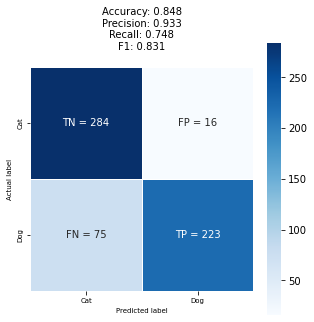

In [34]:
plt.figure(figsize=(5,5))
sns.heatmap(cm_gs_tfidf_mn, annot=np.array(annot_labels),
            fmt="",
            annot_kws={"size": 10},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Cat', 'Dog'],
            yticklabels = ['Cat', 'Dog'],
            );

plt.ylabel('Actual label', fontsize = 7);
plt.xlabel('Predicted label', fontsize = 7);
plt.title('Accuracy: {:.3f}'.format(accuracy_gs_tfidf_mn)+'\n'
          +'Precision: {:.3f}'.format(precision_gs_tfidf_mn)+'\n'
          +'Recall: {:.3f}'.format(recall_gs_tfidf_mn)+'\n'
          +'F1: {:.3f}'.format(f1_gs_tfidf_mn)+'\n', size = 10);
plt.tick_params(labelsize= 7)

C:\Users\flori\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


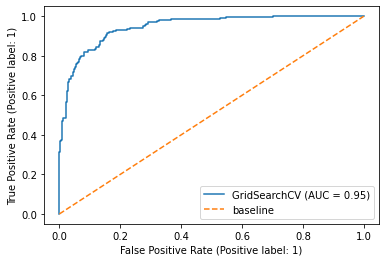

In [35]:
plot_roc_curve(gs_tfidf_mn, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

### Logistic Regression

##### Using CountVectorizer

##### Create a Pipeline to identify best CountVectorizer parameters

In [36]:
pipe_cv_lr = Pipeline([('cvec_lr', CountVectorizer()),
                ('lr_cv', LogisticRegression())])

In [37]:
pipe_cv_lr.get_params()

{'memory': None,
 'steps': [('cvec_lr', CountVectorizer()), ('lr_cv', LogisticRegression())],
 'verbose': False,
 'cvec_lr': CountVectorizer(),
 'lr_cv': LogisticRegression(),
 'cvec_lr__analyzer': 'word',
 'cvec_lr__binary': False,
 'cvec_lr__decode_error': 'strict',
 'cvec_lr__dtype': numpy.int64,
 'cvec_lr__encoding': 'utf-8',
 'cvec_lr__input': 'content',
 'cvec_lr__lowercase': True,
 'cvec_lr__max_df': 1.0,
 'cvec_lr__max_features': None,
 'cvec_lr__min_df': 1,
 'cvec_lr__ngram_range': (1, 1),
 'cvec_lr__preprocessor': None,
 'cvec_lr__stop_words': None,
 'cvec_lr__strip_accents': None,
 'cvec_lr__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec_lr__tokenizer': None,
 'cvec_lr__vocabulary': None,
 'lr_cv__C': 1.0,
 'lr_cv__class_weight': None,
 'lr_cv__dual': False,
 'lr_cv__fit_intercept': True,
 'lr_cv__intercept_scaling': 1,
 'lr_cv__l1_ratio': None,
 'lr_cv__max_iter': 100,
 'lr_cv__multi_class': 'auto',
 'lr_cv__n_jobs': None,
 'lr_cv__penalty': 'l2',
 'lr_cv__random_state': None,

##### Define GridSearchCV parameters

In [38]:
pipe_cv_lr_params = {
    'cvec_lr__max_features': [4_000], #[3_000, 4_000, 7_000, 9_000],
    'cvec_lr__min_df': [2], #[2, 3],
    'cvec_lr__max_df': [0.5], #[0.5 ,.7 ,.9],
    'cvec_lr__ngram_range': [(1,1)], #[(1,1), (1,2)],
    'lr_cv__C': [0.1], #[1.0, 0.1, 0.01],
    'lr_cv__penalty': ['l2'],
    'lr_cv__solver': ['liblinear']} #['newton-cg', 'lbfgs', 'liblinear']}

##### Instantiate GridSearchCV

In [39]:
gs_cv_lr = GridSearchCV(pipe_cv_lr, param_grid=pipe_cv_lr_params, cv=5)

In [40]:
gs_cv_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec_lr', CountVectorizer()),
                                       ('lr_cv', LogisticRegression())]),
             param_grid={'cvec_lr__max_df': [0.5],
                         'cvec_lr__max_features': [4000],
                         'cvec_lr__min_df': [2],
                         'cvec_lr__ngram_range': [(1, 1)], 'lr_cv__C': [0.1],
                         'lr_cv__penalty': ['l2'],
                         'lr_cv__solver': ['liblinear']})

In [41]:
gs_cv_lr.best_score_

0.8528016296640107

In [42]:
gs_cv_lr.best_params_

{'cvec_lr__max_df': 0.5,
 'cvec_lr__max_features': 4000,
 'cvec_lr__min_df': 2,
 'cvec_lr__ngram_range': (1, 1),
 'lr_cv__C': 0.1,
 'lr_cv__penalty': 'l2',
 'lr_cv__solver': 'liblinear'}

In [43]:
crossval_gs_cv_lr = cross_val_score(gs_cv_lr, X_train, y_train, cv=5)
crossvalavg_gs_cv_lr = cross_val_score(gs_cv_lr, X_train, y_train, cv=5).mean()
gs_cv_lr_score = gs_cv_lr.score(X_train, y_train)

print(f'CrossVal Score:{crossval_gs_cv_lr}')
print(f'Average CrossVal Score: {crossvalavg_gs_cv_lr}')
print(f'Model Score: {gs_cv_lr_score}')

CrossVal Score:[0.86021505 0.85663082 0.88888889 0.84172662 0.81654676]
Average CrossVal Score: 0.8528016296640107
Model Score: 0.9734386216798278


In [44]:
y_pred_gs_cv_lr = gs_cv_lr.predict(X_test)

accuracy_gs_cv_lr = accuracy_score(y_test, y_pred_gs_cv_lr)
recall_gs_cv_lr = recall_score(y_test, y_pred_gs_cv_lr)
precision_gs_cv_lr = precision_score(y_test, y_pred_gs_cv_lr)
f1_gs_cv_lr = f1_score(y_test, y_pred_gs_cv_lr)

print(f'Prediction Accuracy: {accuracy_gs_cv_lr}\nPrediction Recall: {recall_gs_cv_lr}\nPrediction Precision: {precision_gs_cv_lr}\nPrediction F1: {f1_gs_cv_lr}')

Prediction Accuracy: 0.8444816053511706
Prediction Recall: 0.889261744966443
Prediction Precision: 0.8153846153846154
Prediction F1: 0.8507223113964687


In [45]:
# Plotting Confusion Matrix

cm_gs_cv_lr = confusion_matrix(y_test, y_pred_gs_cv_lr)

annot_labels = []
for index,value in enumerate(cm_gs_cv_lr):
    if index == 0:
        annot_labels.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        annot_labels.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])]);

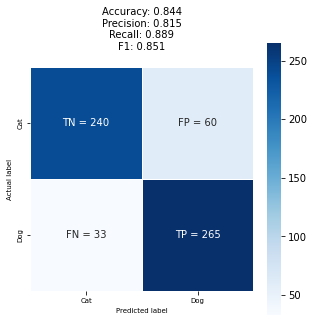

In [46]:
plt.figure(figsize=(5,5))
sns.heatmap(cm_gs_cv_lr, annot=np.array(annot_labels),
            fmt="",
            annot_kws={"size": 10},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Cat', 'Dog'],
            yticklabels = ['Cat', 'Dog'],
            );

plt.ylabel('Actual label', fontsize = 7);
plt.xlabel('Predicted label', fontsize = 7);
plt.title('Accuracy: {:.3f}'.format(accuracy_gs_cv_lr)+'\n'
          +'Precision: {:.3f}'.format(precision_gs_cv_lr)+'\n'
          +'Recall: {:.3f}'.format(recall_gs_cv_lr)+'\n'
          +'F1: {:.3f}'.format(f1_gs_cv_lr)+'\n', size = 10);
plt.tick_params(labelsize= 7)

C:\Users\flori\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


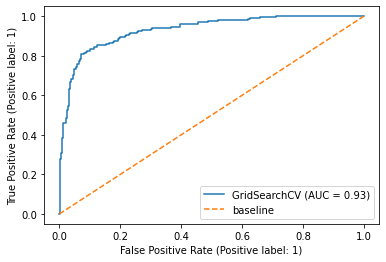

In [47]:
plot_roc_curve(gs_cv_lr, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

### Logistic Regression

##### Using TF-IDF

##### Create a Pipeline to identify best CountVectorizer parameters

In [48]:
pipe_tfidf_lr = Pipeline([('tfidf_lr', TfidfVectorizer()),
                ('lr_tfidf', LogisticRegression())])

In [49]:
pipe_tfidf_lr.get_params()

{'memory': None,
 'steps': [('tfidf_lr', TfidfVectorizer()),
  ('lr_tfidf', LogisticRegression())],
 'verbose': False,
 'tfidf_lr': TfidfVectorizer(),
 'lr_tfidf': LogisticRegression(),
 'tfidf_lr__analyzer': 'word',
 'tfidf_lr__binary': False,
 'tfidf_lr__decode_error': 'strict',
 'tfidf_lr__dtype': numpy.float64,
 'tfidf_lr__encoding': 'utf-8',
 'tfidf_lr__input': 'content',
 'tfidf_lr__lowercase': True,
 'tfidf_lr__max_df': 1.0,
 'tfidf_lr__max_features': None,
 'tfidf_lr__min_df': 1,
 'tfidf_lr__ngram_range': (1, 1),
 'tfidf_lr__norm': 'l2',
 'tfidf_lr__preprocessor': None,
 'tfidf_lr__smooth_idf': True,
 'tfidf_lr__stop_words': None,
 'tfidf_lr__strip_accents': None,
 'tfidf_lr__sublinear_tf': False,
 'tfidf_lr__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf_lr__tokenizer': None,
 'tfidf_lr__use_idf': True,
 'tfidf_lr__vocabulary': None,
 'lr_tfidf__C': 1.0,
 'lr_tfidf__class_weight': None,
 'lr_tfidf__dual': False,
 'lr_tfidf__fit_intercept': True,
 'lr_tfidf__intercept_scaling': 1

##### Define GridSearchCV parameters

In [50]:
pipe_tfidf_lr_params = {
    'tfidf_lr__max_features': [3_000], #[3_000, 4_000, 7_000, 9_000],
    'tfidf_lr__min_df': [2], #[2, 3],
    'tfidf_lr__max_df': [0.5], #[0.5 ,.7 ,.9],
    'lr_tfidf__C': [1.0], #[1.0, 0.1, 0.01],
    'lr_tfidf__penalty': ['l2'],
    'lr_tfidf__solver': ['newton-cg']} #['newton-cg', 'lbfgs', 'liblinear']}

##### Instantiate GridSearchCV

In [51]:
gs_tfidf_lr = GridSearchCV(pipe_tfidf_lr, param_grid=pipe_tfidf_lr_params, cv=5)

In [52]:
gs_tfidf_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf_lr', TfidfVectorizer()),
                                       ('lr_tfidf', LogisticRegression())]),
             param_grid={'lr_tfidf__C': [1.0], 'lr_tfidf__penalty': ['l2'],
                         'lr_tfidf__solver': ['newton-cg'],
                         'tfidf_lr__max_df': [0.5],
                         'tfidf_lr__max_features': [3000],
                         'tfidf_lr__min_df': [2]})

In [53]:
gs_tfidf_lr.best_score_

0.8571130192620098

In [54]:
gs_tfidf_lr.best_params_

{'lr_tfidf__C': 1.0,
 'lr_tfidf__penalty': 'l2',
 'lr_tfidf__solver': 'newton-cg',
 'tfidf_lr__max_df': 0.5,
 'tfidf_lr__max_features': 3000,
 'tfidf_lr__min_df': 2}

In [55]:
crossval_gs_tfidf_lr = cross_val_score(gs_tfidf_lr, X_train, y_train, cv=5)
crossvalavg_gs_tfidf_lr = cross_val_score(gs_tfidf_lr, X_train, y_train, cv=5).mean()
gs_tfidf_lr_score = gs_tfidf_lr.score(X_train, y_train)

print(f'CrossVal Score:{crossval_gs_tfidf_lr}')
print(f'Average CrossVal Score: {crossvalavg_gs_tfidf_lr}')
print(f'Model Score: {gs_tfidf_lr_score}')

CrossVal Score:[0.85304659 0.8781362  0.88172043 0.85251799 0.82014388]
Average CrossVal Score: 0.8571130192620098
Model Score: 0.95908111988514


In [56]:
y_pred_gs_tfidf_lr = gs_tfidf_lr.predict(X_test)

accuracy_gs_tfidf_lr = accuracy_score(y_test, y_pred_gs_tfidf_lr)
recall_gs_tfidf_lr = recall_score(y_test, y_pred_gs_tfidf_lr)
precision_gs_tfidf_lr = precision_score(y_test, y_pred_gs_tfidf_lr)
f1_gs_tfidf_lr = f1_score(y_test, y_pred_gs_tfidf_lr)

print(f'Prediction Accuracy: {accuracy_gs_tfidf_lr}\nPrediction Recall: {recall_gs_tfidf_lr}\nPrediction Precision: {precision_gs_tfidf_lr}\nPrediction F1: {f1_gs_tfidf_lr}')

Prediction Accuracy: 0.8578595317725752
Prediction Recall: 0.8825503355704698
Prediction Precision: 0.8402555910543131
Prediction F1: 0.8608837970540099


In [57]:
# Plotting Confusion Matrix

cm_gs_tfidf_lr = confusion_matrix(y_test, y_pred_gs_tfidf_lr)

annot_labels = []
for index,value in enumerate(cm_gs_tfidf_lr):
    if index == 0:
        annot_labels.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        annot_labels.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])]);

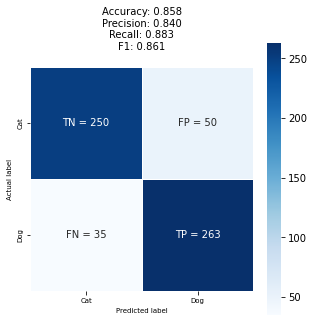

In [58]:
plt.figure(figsize=(5,5))
sns.heatmap(cm_gs_tfidf_lr, annot=np.array(annot_labels),
            fmt="",
            annot_kws={"size": 10},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Cat', 'Dog'],
            yticklabels = ['Cat', 'Dog'],
            );

plt.ylabel('Actual label', fontsize = 7);
plt.xlabel('Predicted label', fontsize = 7);
plt.title('Accuracy: {:.3f}'.format(accuracy_gs_tfidf_lr)+'\n'
          +'Precision: {:.3f}'.format(precision_gs_tfidf_lr)+'\n'
          +'Recall: {:.3f}'.format(recall_gs_tfidf_lr)+'\n'
          +'F1: {:.3f}'.format(f1_gs_tfidf_lr)+'\n', size = 10);
plt.tick_params(labelsize= 7)

C:\Users\flori\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


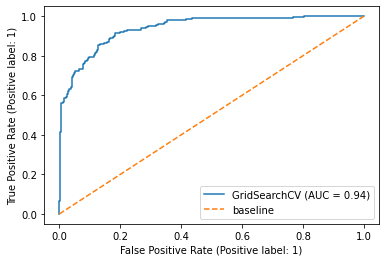

In [59]:
plot_roc_curve(gs_tfidf_lr, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

### K Nearest Neighbours

##### Using CountVectorizer

##### Create a Pipeline to identify best CountVectorizer parameters

In [60]:
pipe_cv_knn = Pipeline([('cvec_knn', CountVectorizer()),
                ('knn_cv', KNeighborsClassifier())])

In [61]:
pipe_cv_knn.get_params()

{'memory': None,
 'steps': [('cvec_knn', CountVectorizer()),
  ('knn_cv', KNeighborsClassifier())],
 'verbose': False,
 'cvec_knn': CountVectorizer(),
 'knn_cv': KNeighborsClassifier(),
 'cvec_knn__analyzer': 'word',
 'cvec_knn__binary': False,
 'cvec_knn__decode_error': 'strict',
 'cvec_knn__dtype': numpy.int64,
 'cvec_knn__encoding': 'utf-8',
 'cvec_knn__input': 'content',
 'cvec_knn__lowercase': True,
 'cvec_knn__max_df': 1.0,
 'cvec_knn__max_features': None,
 'cvec_knn__min_df': 1,
 'cvec_knn__ngram_range': (1, 1),
 'cvec_knn__preprocessor': None,
 'cvec_knn__stop_words': None,
 'cvec_knn__strip_accents': None,
 'cvec_knn__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec_knn__tokenizer': None,
 'cvec_knn__vocabulary': None,
 'knn_cv__algorithm': 'auto',
 'knn_cv__leaf_size': 30,
 'knn_cv__metric': 'minkowski',
 'knn_cv__metric_params': None,
 'knn_cv__n_jobs': None,
 'knn_cv__n_neighbors': 5,
 'knn_cv__p': 2,
 'knn_cv__weights': 'uniform'}

##### Define GridSearchCV parameters

In [62]:
pipe_cv_knn_params = {
    'cvec_knn__max_features': [4_000], #[3_000, 4_000, 7_000, 9_000],
    'cvec_knn__min_df': [2], #[2, 3],
    'cvec_knn__max_df': [0.5], #[0.5 ,.7 ,.9],
    'cvec_knn__ngram_range': [(1,1)], #[(1,1), (1,2)],
    'knn_cv__weights': ['uniform'], #['uniform','distance'],
    'knn_cv__n_neighbors': [1]} #[1,3,5]}

##### Instantiate GridSearchCV

In [63]:
gs_cv_knn = GridSearchCV(pipe_cv_knn, param_grid=pipe_cv_knn_params, cv=5)

In [64]:
gs_cv_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec_knn', CountVectorizer()),
                                       ('knn_cv', KNeighborsClassifier())]),
             param_grid={'cvec_knn__max_df': [0.5],
                         'cvec_knn__max_features': [4000],
                         'cvec_knn__min_df': [2],
                         'cvec_knn__ngram_range': [(1, 1)],
                         'knn_cv__n_neighbors': [1],
                         'knn_cv__weights': ['uniform']})

In [65]:
gs_cv_knn.best_score_

0.6503932338000568

In [66]:
gs_cv_knn.best_params_

{'cvec_knn__max_df': 0.5,
 'cvec_knn__max_features': 4000,
 'cvec_knn__min_df': 2,
 'cvec_knn__ngram_range': (1, 1),
 'knn_cv__n_neighbors': 1,
 'knn_cv__weights': 'uniform'}

In [67]:
crossval_gs_cv_knn = cross_val_score(gs_cv_knn, X_train, y_train, cv=5)
crossvalavg_gs_cv_knn = cross_val_score(gs_cv_knn, X_train, y_train, cv=5).mean()
gs_cv_knn_score = gs_cv_knn.score(X_train, y_train)

print(f'CrossVal Score:{crossval_gs_cv_knn}')
print(f'Average CrossVal Score: {crossvalavg_gs_cv_knn}')
print(f'Model Score: {gs_cv_knn_score}')

CrossVal Score:[0.65949821 0.64157706 0.65232975 0.67985612 0.61870504]
Average CrossVal Score: 0.6503932338000568
Model Score: 0.9985642498205313


In [68]:
y_pred_gs_cv_knn = gs_cv_knn.predict(X_test)

accuracy_gs_cv_knn = accuracy_score(y_test, y_pred_gs_cv_knn)
recall_gs_cv_knn = recall_score(y_test, y_pred_gs_cv_knn)
precision_gs_cv_knn = precision_score(y_test, y_pred_gs_cv_knn)
f1_gs_cv_knn = f1_score(y_test, y_pred_gs_cv_knn)

print(f'Prediction Accuracy: {accuracy_gs_cv_knn}\nPrediction Recall: {recall_gs_cv_knn}\nPrediction Precision: {precision_gs_cv_knn}\nPrediction F1: {f1_gs_cv_knn}')

Prediction Accuracy: 0.6471571906354515
Prediction Recall: 0.9093959731543624
Prediction Precision: 0.5956043956043956
Prediction F1: 0.7197875166002655


In [69]:
# Plotting Confusion Matrix

cm_gs_cv_knn = confusion_matrix(y_test, y_pred_gs_cv_knn)

annot_labels = []
for index,value in enumerate(cm_gs_cv_knn):
    if index == 0:
        annot_labels.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        annot_labels.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])]);

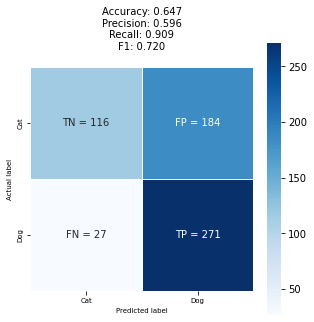

In [70]:
plt.figure(figsize=(5,5))
sns.heatmap(cm_gs_cv_knn, annot=np.array(annot_labels),
            fmt="",
            annot_kws={"size": 10},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Cat', 'Dog'],
            yticklabels = ['Cat', 'Dog'],
            );

plt.ylabel('Actual label', fontsize = 7);
plt.xlabel('Predicted label', fontsize = 7);
plt.title('Accuracy: {:.3f}'.format(accuracy_gs_cv_knn)+'\n'
          +'Precision: {:.3f}'.format(precision_gs_cv_knn)+'\n'
          +'Recall: {:.3f}'.format(recall_gs_cv_knn)+'\n'
          +'F1: {:.3f}'.format(f1_gs_cv_knn)+'\n', size = 10);
plt.tick_params(labelsize= 7)

C:\Users\flori\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


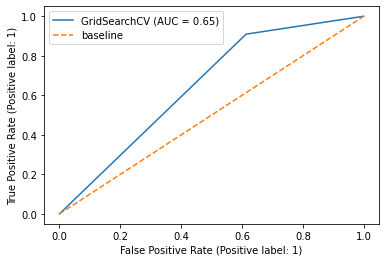

In [71]:
plot_roc_curve(gs_cv_knn, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

##### Using TF-IDF

##### Create a Pipeline to identify best TFIDF parameters

In [72]:
pipe_tfidf_knn = Pipeline([('tfidf_knn', TfidfVectorizer()),
                ('knn_tfidf', KNeighborsClassifier())])

In [73]:
pipe_tfidf_knn.get_params()

{'memory': None,
 'steps': [('tfidf_knn', TfidfVectorizer()),
  ('knn_tfidf', KNeighborsClassifier())],
 'verbose': False,
 'tfidf_knn': TfidfVectorizer(),
 'knn_tfidf': KNeighborsClassifier(),
 'tfidf_knn__analyzer': 'word',
 'tfidf_knn__binary': False,
 'tfidf_knn__decode_error': 'strict',
 'tfidf_knn__dtype': numpy.float64,
 'tfidf_knn__encoding': 'utf-8',
 'tfidf_knn__input': 'content',
 'tfidf_knn__lowercase': True,
 'tfidf_knn__max_df': 1.0,
 'tfidf_knn__max_features': None,
 'tfidf_knn__min_df': 1,
 'tfidf_knn__ngram_range': (1, 1),
 'tfidf_knn__norm': 'l2',
 'tfidf_knn__preprocessor': None,
 'tfidf_knn__smooth_idf': True,
 'tfidf_knn__stop_words': None,
 'tfidf_knn__strip_accents': None,
 'tfidf_knn__sublinear_tf': False,
 'tfidf_knn__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf_knn__tokenizer': None,
 'tfidf_knn__use_idf': True,
 'tfidf_knn__vocabulary': None,
 'knn_tfidf__algorithm': 'auto',
 'knn_tfidf__leaf_size': 30,
 'knn_tfidf__metric': 'minkowski',
 'knn_tfidf__metric_p

##### Define GridSearchCV parameters

In [74]:
pipe_tfidf_knn_params = {
    'tfidf_knn__max_features': [3_000], #[3_000, 4_000, 7_000, 9_000],
    'tfidf_knn__min_df': [2], #[2, 3],
    'tfidf_knn__max_df': [0.5], #[0.5 ,.7 ,.9],
    'knn_tfidf__weights': ['distance'], #['uniform','distance'],
    'knn_tfidf__n_neighbors': [5]} #[1,3,5]}

##### Instantiate GridSearchCV

In [75]:
gs_tfidf_knn = GridSearchCV(pipe_tfidf_knn, param_grid=pipe_tfidf_knn_params, cv=5)

In [76]:
gs_tfidf_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf_knn', TfidfVectorizer()),
                                       ('knn_tfidf', KNeighborsClassifier())]),
             param_grid={'knn_tfidf__n_neighbors': [5],
                         'knn_tfidf__weights': ['distance'],
                         'tfidf_knn__max_df': [0.5],
                         'tfidf_knn__max_features': [3000],
                         'tfidf_knn__min_df': [2]})

In [77]:
gs_tfidf_knn.best_score_

0.5555736056316237

In [78]:
gs_tfidf_knn.best_params_

{'knn_tfidf__n_neighbors': 5,
 'knn_tfidf__weights': 'distance',
 'tfidf_knn__max_df': 0.5,
 'tfidf_knn__max_features': 3000,
 'tfidf_knn__min_df': 2}

In [79]:
crossval_gs_tfidf_knn = cross_val_score(gs_tfidf_knn, X_train, y_train, cv=5)
crossvalavg_gs_tfidf_knn = cross_val_score(gs_tfidf_knn, X_train, y_train, cv=5).mean()
gs_tfidf_knn_score = gs_tfidf_knn.score(X_train, y_train)

print(f'CrossVal Score:{crossval_gs_tfidf_knn}')
print(f'Average CrossVal Score: {crossvalavg_gs_tfidf_knn}')
print(f'Model Score: {gs_tfidf_knn_score}')

CrossVal Score:[0.50537634 0.73835125 0.50896057 0.50719424 0.51798561]
Average CrossVal Score: 0.5555736056316237
Model Score: 0.9985642498205313


In [80]:
y_pred_gs_tfidf_knn = gs_tfidf_knn.predict(X_test)

accuracy_gs_tfidf_knn = accuracy_score(y_test, y_pred_gs_tfidf_knn)
recall_gs_tfidf_knn = recall_score(y_test, y_pred_gs_tfidf_knn)
precision_gs_tfidf_knn = precision_score(y_test, y_pred_gs_tfidf_knn)
f1_gs_tfidf_knn = f1_score(y_test, y_pred_gs_tfidf_knn)

print(f'Prediction Accuracy: {accuracy_gs_tfidf_knn}\nPrediction Recall: {recall_gs_tfidf_knn}\nPrediction Precision: {precision_gs_tfidf_knn}\nPrediction F1: {f1_gs_tfidf_knn}')

Prediction Accuracy: 0.5150501672240803
Prediction Recall: 0.9966442953020134
Prediction Precision: 0.5068259385665529
Prediction F1: 0.671945701357466


In [81]:
# Plotting Confusion Matrix

cm_gs_tfidf_knn = confusion_matrix(y_test, y_pred_gs_tfidf_knn)

annot_labels = []
for index,value in enumerate(cm_gs_tfidf_knn):
    if index == 0:
        annot_labels.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        annot_labels.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])]);

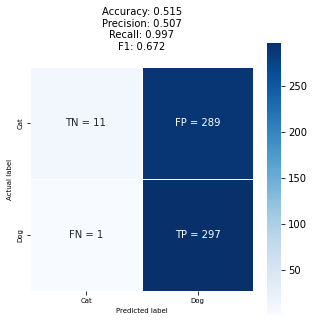

In [82]:
plt.figure(figsize=(5,5))
sns.heatmap(cm_gs_tfidf_knn, annot=np.array(annot_labels),
            fmt="",
            annot_kws={"size": 10},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Cat', 'Dog'],
            yticklabels = ['Cat', 'Dog'],
            );

plt.ylabel('Actual label', fontsize = 7);
plt.xlabel('Predicted label', fontsize = 7);
plt.title('Accuracy: {:.3f}'.format(accuracy_gs_tfidf_knn)+'\n'
          +'Precision: {:.3f}'.format(precision_gs_tfidf_knn)+'\n'
          +'Recall: {:.3f}'.format(recall_gs_tfidf_knn)+'\n'
          +'F1: {:.3f}'.format(f1_gs_tfidf_knn)+'\n', size = 10);
plt.tick_params(labelsize= 7)

C:\Users\flori\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


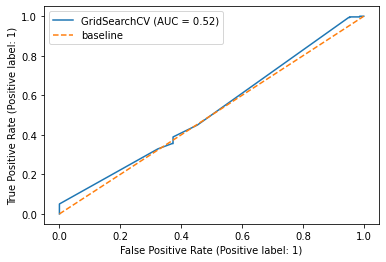

In [83]:
plot_roc_curve(gs_tfidf_knn, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

### Random Forest

##### Using CountVectorizer

##### Create a Pipeline to identify best CountVectorizer parameters

In [84]:
pipe_cv_rf = Pipeline([('cvec_rf', CountVectorizer()),
                ('rf_cv', RandomForestClassifier())])

In [85]:
pipe_cv_rf.get_params()

{'memory': None,
 'steps': [('cvec_rf', CountVectorizer()),
  ('rf_cv', RandomForestClassifier())],
 'verbose': False,
 'cvec_rf': CountVectorizer(),
 'rf_cv': RandomForestClassifier(),
 'cvec_rf__analyzer': 'word',
 'cvec_rf__binary': False,
 'cvec_rf__decode_error': 'strict',
 'cvec_rf__dtype': numpy.int64,
 'cvec_rf__encoding': 'utf-8',
 'cvec_rf__input': 'content',
 'cvec_rf__lowercase': True,
 'cvec_rf__max_df': 1.0,
 'cvec_rf__max_features': None,
 'cvec_rf__min_df': 1,
 'cvec_rf__ngram_range': (1, 1),
 'cvec_rf__preprocessor': None,
 'cvec_rf__stop_words': None,
 'cvec_rf__strip_accents': None,
 'cvec_rf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec_rf__tokenizer': None,
 'cvec_rf__vocabulary': None,
 'rf_cv__bootstrap': True,
 'rf_cv__ccp_alpha': 0.0,
 'rf_cv__class_weight': None,
 'rf_cv__criterion': 'gini',
 'rf_cv__max_depth': None,
 'rf_cv__max_features': 'auto',
 'rf_cv__max_leaf_nodes': None,
 'rf_cv__max_samples': None,
 'rf_cv__min_impurity_decrease': 0.0,
 'rf_cv__min_s

##### Define GridSearchCV parameters

In [86]:
pipe_cv_rf_params = {
    'cvec_rf__max_features': [3_000], #[3_000, 4_000, 7_000, 9_000],
    'cvec_rf__min_df': [2], #[2, 3],
    'cvec_rf__max_df': [0.9], #[0.5 ,.7 ,.9],
    'cvec_rf__ngram_range': [(1,1)], #[(1,1), (1,2)],
    'rf_cv__max_depth' : [6], #[4,5,6],
    'rf_cv__n_estimators': [1500]} #[500,1000,1500]}

##### Instantiate GridSearchCV

In [87]:
gs_cv_rf = GridSearchCV(pipe_cv_rf, param_grid=pipe_cv_rf_params, cv=5)

In [88]:
gs_cv_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec_rf', CountVectorizer()),
                                       ('rf_cv', RandomForestClassifier())]),
             param_grid={'cvec_rf__max_df': [0.9],
                         'cvec_rf__max_features': [3000],
                         'cvec_rf__min_df': [2],
                         'cvec_rf__ngram_range': [(1, 1)],
                         'rf_cv__max_depth': [6],
                         'rf_cv__n_estimators': [1500]})

In [89]:
gs_cv_rf.best_score_

0.806129290116294

In [90]:
gs_cv_rf.best_params_

{'cvec_rf__max_df': 0.9,
 'cvec_rf__max_features': 3000,
 'cvec_rf__min_df': 2,
 'cvec_rf__ngram_range': (1, 1),
 'rf_cv__max_depth': 6,
 'rf_cv__n_estimators': 1500}

In [91]:
crossval_gs_cv_rf = cross_val_score(gs_cv_rf, X_train, y_train, cv=5)
crossvalavg_gs_cv_rf = cross_val_score(gs_cv_rf, X_train, y_train, cv=5).mean()
gs_cv_rf_score = gs_cv_rf.score(X_train, y_train)

print(f'CrossVal Score:{crossval_gs_cv_rf}')
print(f'Average CrossVal Score: {crossvalavg_gs_cv_rf}')
print(f'Model Score: {gs_cv_rf_score}')

CrossVal Score:[0.83512545 0.80645161 0.81362007 0.79136691 0.75179856]
Average CrossVal Score: 0.8032670637683401
Model Score: 0.8923187365398421


In [92]:
y_pred_gs_cv_rf = gs_cv_rf.predict(X_test)

accuracy_gs_cv_rf = accuracy_score(y_test, y_pred_gs_cv_rf)
recall_gs_cv_rf = recall_score(y_test, y_pred_gs_cv_rf)
precision_gs_cv_rf = precision_score(y_test, y_pred_gs_cv_rf)
f1_gs_cv_rf = f1_score(y_test, y_pred_gs_cv_rf)

print(f'Prediction Accuracy: {accuracy_gs_cv_rf}\nPrediction Recall: {recall_gs_cv_rf}\nPrediction Precision: {precision_gs_cv_rf}\nPrediction F1: {f1_gs_cv_rf}')

Prediction Accuracy: 0.8193979933110368
Prediction Recall: 0.8590604026845637
Prediction Precision: 0.7950310559006211
Prediction F1: 0.8258064516129032


In [93]:
# Plotting Confusion Matrix

cm_gs_cv_rf = confusion_matrix(y_test, y_pred_gs_cv_rf)

annot_labels = []
for index,value in enumerate(cm_gs_cv_rf):
    if index == 0:
        annot_labels.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        annot_labels.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])]);

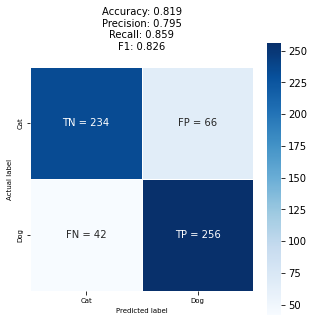

In [94]:
plt.figure(figsize=(5,5))
sns.heatmap(cm_gs_cv_rf, annot=np.array(annot_labels),
            fmt="",
            annot_kws={"size": 10},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Cat', 'Dog'],
            yticklabels = ['Cat', 'Dog'],
            );

plt.ylabel('Actual label', fontsize = 7);
plt.xlabel('Predicted label', fontsize = 7);
plt.title('Accuracy: {:.3f}'.format(accuracy_gs_cv_rf)+'\n'
          +'Precision: {:.3f}'.format(precision_gs_cv_rf)+'\n'
          +'Recall: {:.3f}'.format(recall_gs_cv_rf)+'\n'
          +'F1: {:.3f}'.format(f1_gs_cv_rf)+'\n', size = 10);
plt.tick_params(labelsize= 7)

C:\Users\flori\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


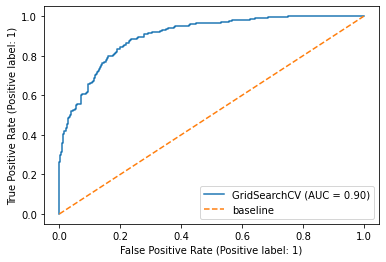

In [95]:
plot_roc_curve(gs_cv_rf, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

##### Using TF-IDF

##### Create a Pipeline to identify best TF-IDF parameters

In [96]:
pipe_tfidf_rf = Pipeline([('tfidf_rf', TfidfVectorizer()),
                ('rf_tfidf', RandomForestClassifier())])

In [97]:
pipe_tfidf_rf.get_params()

{'memory': None,
 'steps': [('tfidf_rf', TfidfVectorizer()),
  ('rf_tfidf', RandomForestClassifier())],
 'verbose': False,
 'tfidf_rf': TfidfVectorizer(),
 'rf_tfidf': RandomForestClassifier(),
 'tfidf_rf__analyzer': 'word',
 'tfidf_rf__binary': False,
 'tfidf_rf__decode_error': 'strict',
 'tfidf_rf__dtype': numpy.float64,
 'tfidf_rf__encoding': 'utf-8',
 'tfidf_rf__input': 'content',
 'tfidf_rf__lowercase': True,
 'tfidf_rf__max_df': 1.0,
 'tfidf_rf__max_features': None,
 'tfidf_rf__min_df': 1,
 'tfidf_rf__ngram_range': (1, 1),
 'tfidf_rf__norm': 'l2',
 'tfidf_rf__preprocessor': None,
 'tfidf_rf__smooth_idf': True,
 'tfidf_rf__stop_words': None,
 'tfidf_rf__strip_accents': None,
 'tfidf_rf__sublinear_tf': False,
 'tfidf_rf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf_rf__tokenizer': None,
 'tfidf_rf__use_idf': True,
 'tfidf_rf__vocabulary': None,
 'rf_tfidf__bootstrap': True,
 'rf_tfidf__ccp_alpha': 0.0,
 'rf_tfidf__class_weight': None,
 'rf_tfidf__criterion': 'gini',
 'rf_tfidf__max

##### Define GridSearchCV parameters

In [99]:
pipe_tfidf_rf_params = {
    'tfidf_rf__max_features': [7000], #[3_000, 4_000, 7_000, 9_000],
    'tfidf_rf__min_df': [3], #[2, 3],
    'tfidf_rf__max_df': [0.9], #[0.5 ,.7 ,.9],
    'rf_tfidf__max_depth' : [6], #[4,5,6],
    'rf_tfidf__n_estimators': [1000]} #[500,1000,1500]}

##### Instantiate GridSearchCV

In [100]:
gs_tfidf_rf = GridSearchCV(pipe_tfidf_rf, param_grid=pipe_tfidf_rf_params, cv=5)

In [101]:
gs_tfidf_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf_rf', TfidfVectorizer()),
                                       ('rf_tfidf', RandomForestClassifier())]),
             param_grid={'rf_tfidf__max_depth': [6],
                         'rf_tfidf__n_estimators': [1000],
                         'tfidf_rf__max_df': [0.9],
                         'tfidf_rf__max_features': [7000],
                         'tfidf_rf__min_df': [3]})

In [102]:
gs_tfidf_rf.best_score_

0.8011036332224544

In [103]:
gs_tfidf_rf.best_params_

{'rf_tfidf__max_depth': 6,
 'rf_tfidf__n_estimators': 1000,
 'tfidf_rf__max_df': 0.9,
 'tfidf_rf__max_features': 7000,
 'tfidf_rf__min_df': 3}

In [104]:
crossval_gs_tfidf_rf = cross_val_score(gs_tfidf_rf, X_train, y_train, cv=5)
crossvalavg_gs_tfidf_rf = cross_val_score(gs_tfidf_rf, X_train, y_train, cv=5).mean()
gs_tfidf_rf_score = gs_tfidf_rf.score(X_train, y_train)

print(f'CrossVal Score:{crossval_gs_tfidf_rf}')
print(f'Average CrossVal Score: {crossvalavg_gs_tfidf_rf}')
print(f'Model Score: {gs_tfidf_rf_score}')

CrossVal Score:[0.83512545 0.81362007 0.82437276 0.80935252 0.75899281]
Average CrossVal Score: 0.7968025579536371
Model Score: 0.908829863603733


In [105]:
y_pred_gs_tfidf_rf = gs_tfidf_rf.predict(X_test)

accuracy_gs_tfidf_rf = accuracy_score(y_test, y_pred_gs_tfidf_rf)
recall_gs_tfidf_rf = recall_score(y_test, y_pred_gs_tfidf_rf)
precision_gs_tfidf_rf = precision_score(y_test, y_pred_gs_tfidf_rf)
f1_gs_tfidf_rf = f1_score(y_test, y_pred_gs_tfidf_rf)

print(f'Prediction Accuracy: {accuracy_gs_tfidf_rf}\nPrediction Recall: {recall_gs_tfidf_rf}\nPrediction Precision: {precision_gs_tfidf_rf}\nPrediction F1: {f1_gs_tfidf_rf}')

Prediction Accuracy: 0.8160535117056856
Prediction Recall: 0.8389261744966443
Prediction Precision: 0.8012820512820513
Prediction F1: 0.819672131147541


In [106]:
# Plotting Confusion Matrix

cm_gs_tfidf_rf = confusion_matrix(y_test, y_pred_gs_tfidf_rf)

annot_labels = []
for index,value in enumerate(cm_gs_tfidf_rf):
    if index == 0:
        annot_labels.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        annot_labels.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])]);

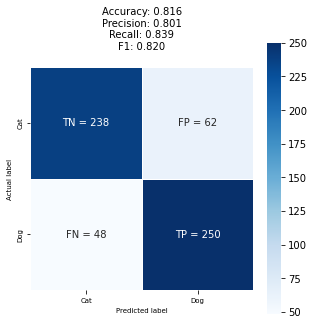

In [107]:
plt.figure(figsize=(5,5))
sns.heatmap(cm_gs_tfidf_rf, annot=np.array(annot_labels),
            fmt="",
            annot_kws={"size": 10},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Cat', 'Dog'],
            yticklabels = ['Cat', 'Dog'],
            );

plt.ylabel('Actual label', fontsize = 7);
plt.xlabel('Predicted label', fontsize = 7);
plt.title('Accuracy: {:.3f}'.format(accuracy_gs_tfidf_rf)+'\n'
          +'Precision: {:.3f}'.format(precision_gs_tfidf_rf)+'\n'
          +'Recall: {:.3f}'.format(recall_gs_tfidf_rf)+'\n'
          +'F1: {:.3f}'.format(f1_gs_tfidf_rf)+'\n', size = 10);
plt.tick_params(labelsize= 7)

C:\Users\flori\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


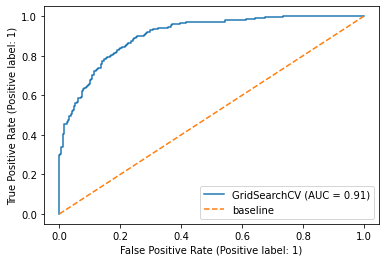

In [108]:
plot_roc_curve(gs_tfidf_rf, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

### Getting the most similar words to Dog and Cat using Word Vectors

In [111]:
# Getting columns name in cat_dog csv

cat_dog.columns

Index(['Unnamed: 0', 'created_utc', 'domain', 'is_robot_indexable', 'selftext',
       'subreddit', 'title', 'post_hint', 'content_word_count',
       'content_lemmatized', 'content_joined'],
      dtype='object')

In [112]:
# Clean data (remove punctuations, remove stopwords, tokenize) using the built in cleaner in gensim

cat_dog['content_wv'] = cat_dog['content_joined'].apply(lambda x: gensim.utils.simple_preprocess(x))

In [113]:
# Dropping irrelevant columns

cat_dog_vectors = cat_dog.drop(labels = ['Unnamed: 0', 'created_utc', 'domain', 'is_robot_indexable', 'selftext',
       'title', 'post_hint', 'content_joined', 'content_lemmatized'], axis= 1)

In [114]:
# Split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(cat_dog_vectors['content_wv'],
                                                    cat_dog_vectors['subreddit'], test_size=0.2)

In [115]:
w2v = gensim.models.Word2Vec(X_train,vector_size = 100, window = 5, min_count =2)

(w2v.wv.most_similar('kitten', topn=30))

[('male', 0.999434769153595),
 ('female', 0.9991138577461243),
 ('week', 0.9972807168960571),
 ('adopted', 0.9962307214736938),
 ('ago', 0.9906973838806152),
 ('month', 0.9887334704399109),
 ('two', 0.9865784049034119),
 ('yr', 0.9847474694252014),
 ('got', 0.984000563621521),
 ('new', 0.983748197555542),
 ('year', 0.9836111664772034),
 ('recently', 0.9813518524169922),
 ('six', 0.9805442690849304),
 ('pyrenees', 0.978244423866272),
 ('neutered', 0.978131115436554),
 ('tabby', 0.9767935872077942),
 ('since', 0.9760797023773193),
 ('puppy', 0.9744033217430115),
 ('moved', 0.9743826985359192),
 ('rescue', 0.9739481806755066),
 ('mix', 0.9729828834533691),
 ('hi', 0.9725870490074158),
 ('spayed', 0.9721556305885315),
 ('weighs', 0.9708226919174194),
 ('corgi', 0.9706730842590332),
 ('introduced', 0.9673599600791931),
 ('beagle', 0.967110812664032),
 ('everyonei', 0.9665867686271667),
 ('half', 0.9663420915603638),
 ('resident', 0.9661742448806763)]

In [116]:
w2v.wv.most_similar('puppy', topn=30)

[('rescue', 0.9996377825737),
 ('since', 0.9996316432952881),
 ('spayed', 0.9995356202125549),
 ('mix', 0.9994555115699768),
 ('hi', 0.9994547963142395),
 ('neutered', 0.9992582201957703),
 ('moved', 0.9989640116691589),
 ('half', 0.9988822340965271),
 ('first', 0.9987640976905823),
 ('tabby', 0.9987428188323975),
 ('recently', 0.9986351728439331),
 ('black', 0.9986200332641602),
 ('resident', 0.9984617233276367),
 ('got', 0.9984613656997681),
 ('named', 0.9983611106872559),
 ('stray', 0.9983401298522949),
 ('shelter', 0.9982818961143494),
 ('introduced', 0.998177707195282),
 ('shepherd', 0.9981620907783508),
 ('couple', 0.9980783462524414),
 ('yo', 0.9980396628379822),
 ('almost', 0.9979636669158936),
 ('new', 0.9978743195533752),
 ('rescued', 0.9978659152984619),
 ('mo', 0.9978654980659485),
 ('yr', 0.9978165626525879),
 ('last', 0.9975569248199463),
 ('three', 0.9974943399429321),
 ('pup', 0.9973388314247131),
 ('brought', 0.9972541928291321)]

## Conclusions

Now that we have re-run our model using Hyperparameters Tuning let's see how our new models compares to the previous ones.

|        Model        	| Data Vectorization 	| Cross Val Score 	| Train Score 	| Test Accuracy 	|    Recall    	|  Precision  	|     F1     	|     AUC     	|
|:-------------------:	|:------------------:	|:---------------:	|:-----------:	|:-------------:	|:------------:	|:-----------:	|:----------:	|-------------	|
| Bernoulli NB        	| Count Vectorizer   	|      0.74%      	|    81.47%   	|     71.07%    	|    78.67%    	|    66.76%   	|   72.23%   	|     0.82    	|
| Bernoulli NB        	| CV with N-Grams    	|      68.91%     	|    83.70%   	|     69.23%    	|    90.90%    	|    62.20%   	|   73.86%   	|     0.83    	|
| Bernoulli NB        	| TF-IDF             	|      73.80%     	|    83.63%   	|     70.73%    	|    80.41%    	|    65.90%   	|   72.44%   	|     0.82    	|
| Multinomial NB      	| Count Vectorizer   	|      87.79%     	|    94.75%   	|     89.63%    	|    86.71%    	|    91.17%   	|   88.88%   	|     0.95    	|
| Multinomial NB      	| CV with N-Grams    	|      75.23%     	|    94.40%   	|     76.75%    	|    80.76%    	|    73.33%   	|   76.87%   	|     0.84    	|
| Multinomial NB      	| TF-IDF             	|      79.47%     	|    93.39%   	|     83.44     	|    67.48%    	|    96.98%   	|   79.58%   	|     0.95    	|
| Gaussian NB         	| Count Vectorizer   	|      77.60%     	|    91.88%   	|     76.42%    	|    81.81%    	|    72.44%   	|   76.84%   	|     0.77    	|
| Gaussian NB         	| CV with N-Grams    	|      74.80%     	|    96.69%   	|     74.08%    	|    63.98%    	|    77.87%   	|   70.24%   	|     0.74    	|
| Gaussian NB         	| TF-IDF             	|      74.80%     	|    97.70%   	|     72.90%    	|    74.47%    	|    70.52%   	|   72.44%   	|     0.73    	|
| Logistic Regression 	| Count Vectorizer   	|      84.70      	|    99.64%   	|     84.44%    	|    89.16%    	|    80.44%   	|   84.57%   	|     0.93    	|
| Logistic Regression 	| CV with N-Grams    	|      73.00%     	|    97.55%   	|     74.24%    	|    87.76%    	|    67.83%   	|   76.52%   	|     0.82    	|
| Logistic Regression 	| TF-IDF             	|      84.99%     	|    96.12%   	|     85.78%    	|    89.51%    	|    82.31%   	|   85.76%   	|     0.94    	|
| K-Nearest Neighbors 	| Count Vectorizer   	|      62.89%     	|    78.24%   	|     60.36%    	|    94.05%    	|    55.01%   	|   69.41%   	|     0.61    	|
| K-Nearest Neighbors 	| CV with N-Grams    	|      54.77%     	|    62.67%   	|     52.84%    	|    99.30%    	|    50.35%   	|   66.82%   	|     0.60    	|
| K-Nearest Neighbors 	| TF-IDF             	|      76.16%     	|    86.93%   	|     81.60%    	|    80.41%    	|    80.98%   	|   80.70%   	|     0.87    	|
| Random Forest       	| Count Vectorizer   	|      79.04%     	|    99.92%   	|     81.10%    	|    78.67%    	|    81.22%   	|   79.92%   	|     0.92    	|
| Random Forest       	| CV with N-Grams    	|      69.34%     	|    99.13%   	|     68.89%    	|    82.86%    	|    63.36%   	|   71.81%   	|     0.80    	|
| Random Forest       	| TF-IDF             	|      79.68%     	|     100%    	|     79.59%    	|    75.52%    	|    80.59%   	|   77.97%   	|     0.91    	|

New models with hyperparameter tunings

|        Model        	| Data Vectorization 	| Cross Val Score 	| Train Score 	| Test Accuracy 	|    Recall    	|  Precision  	|     F1     	|     AUC     	|
|:-------------------:	|:------------------:	|:---------------:	|:-----------:	|:-------------:	|:------------:	|:-----------:	|:----------:	|-------------	|
| Multinomial NB      	| Count Vectorizer   	|      87.86%     	|    96.84%   	|     88.79%    	|    85.23%    	|    91.69%   	|   88.34%   	|     0.95    	|
| Multinomial NB      	| TF-IDF             	|      83.91%     	|    94.83%   	|     84.78%    	|    74.93%    	|    93.30%   	|   83.05%   	|     0.95    	|
| Logistic Regression 	| Count Vectorizer   	|      85.28%     	|    97.34%   	|     84.44%    	|    88.92%    	|    81.53%   	|   85.07%   	|     0.93    	|
| Logistic Regression 	| TF-IDF             	|      85.71%     	|    95.90%   	|     85.78%    	|    88.25%    	|    84.02%   	|   86.08%   	|     0.94    	|
| K-Nearest Neighbors 	| Count Vectorizer   	|      65.03%     	|    99.85%   	|     64.71%    	|    90.93%    	|    59.56%   	|   71.97%   	|     0.65    	|
| K-Nearest Neighbors 	| TF-IDF             	|      55.55%     	|    99.85%   	|     51.50%    	|    99.66%    	|    50.68%   	|   67.19%   	|     0.52    	|
| Random Forest       	| Count Vectorizer   	|      80.25%     	|    88.94%   	|     81.93%    	|    86.24%    	|    79.32%   	|   82.63%   	|     0.90    	|
| Random Forest       	| TF-IDF             	|      79.68%     	|    90.88%   	|     81.60%    	|    83.89%    	|    80.12%   	|   81.86%   	|     0.91    	|

We can see that using the Hyperparameters tuning did not allow our models to gain in much accuracy. However, it seems that our models are less prone to overfitting and Recall, Precision and F1 seems closer.

Our best model remains the Multinomial Naive Bayes with Count Vecotrizer. Even thought, it does not have the best Precision or Recall, it is the model with the highest accuracy, f1 score and AUC.


As such this is the model that we will selecting for our project.

We could also try to rerun our model with new parameters in our pipelines to see if we can fine tune the hyperparameter tuning even more.

This could allow us to potentially increase the results of our models.

###### Best model parameters

| Min ocurence 	| Max occurence 	| Max number of features 	| N-Gram Range       	|
|--------------	|---------------	|------------------------	|--------------------	|
|       2      	| 50% of corpus 	|          9000          	| Unigram and Bigram 	|

Using our model, we will be able to precit and assign queries related to cats and dogs to our team of experts with an precision of almost 92%.

Using Word Vectors we are also able to provide insights on the most similar words in our traiend dataset.

This can be useful to provide recommended articles based on the users searches or queries.

##### Limitations

This model is specific to cats and dogs.
* We can consider extending it to other popular animals.

Recommendations and sources for articles is based on global trends.
* In order to tailor the content to a particular population, we might want to explore using localised sources of informations